<h1><center>Primal Dual Hybrid Gradient Algorithm: Tomography </center></h1>

In this demo, we learn how to use the Primal Dual hubrid algorithm introduced in [ChampollePock](https://hal.archives-ouvertes.fr/hal-00490826/document) for Tomography Reconstruction under an edge-preserving prior, i.e., the __Total variation regularisation__, see [ROF](#ROF). 

## Learning objectives

1. Non-smooth minimisation problem using PDHG algorithm.
1. Setup and run PDHG with $L^{1}$ norm regularisation. __(No BlockFramework)__
1. Use BlockFunction and setup PDHG within the __Block Framework__.
1. Run Total variation reconstruction with different regularising parameters and compared with FBP and SIRT reconstructions.

## Prerequisites

- AcquisitionData, AcquisitionGeometry, AstraProjectorSimple.
- BlockOperator, Gradient.
- FBP, SIRT, CGLS, Tikhonov.

In the figure below, we present 4 different tomography reconstructions that we discuss in this demo. We have seen in the previous demo that the __Tikhonov regularisation__ with $L = \nabla$ was able to remove the noise but could not preserve the edges. However, this can be achieved with the the total variation reconstruction.

<img src="images/recon_all_tomo.jpeg"  width="800"/>

The minimisation problem for Total variation Tomography reconstuction is 

<a id='TomoTV'></a>
$$ \underset{u}{\operatorname{argmin}} \frac{1}{2} \| \mathcal{A} u - g\|^{2} + \alpha\,\mathrm{TV}(u) +  \mathbb{I}_{\{u>0\}}(u) $$

where,
1. The total variation is $$\mathrm{TV}(u) = \|\nabla u \|_{2,1} = \sum \sqrt{ (\partial_{y}u)^{2} + (\partial_{x}u)^{2} }$$
1. g is the Acqusisition data obtained from the detector.
1. $\mathcal{A}$ is the projection operator ( _Radon transform_ ) that maps from an image-space to an acquisition space, i.e., $\mathcal{A} : X \rightarrow Y, $ where X is an __ImageGeometry__ and Y is an __AcquisitionGeometry__.
1. $\alpha$: regularising parameter that measures a trade-off between the fidelity and the regulariser terms.
1. $\mathbb{I}_{\{u>0\}}(u) : = 
\begin{cases}
0, & \mbox{ if } u>0\\
\infty , & \mbox{ otherwise}
\quad
\end{cases}
$, $\quad$ a positivity constraint for the minimiser $u$.

In order to use the PDHG algorithm for the problem above, we need to express our minimisation problem into the following form:

<a id='PDHG_form'></a>
$$\min_{u} \mathcal{F}(K u) + \mathcal{G}(u)$$

where we assume that:

1. $\mathcal{F}$, $\mathcal{G}$ are __convex__ functionals
    
    - $\mathcal{F}: Y \rightarrow \mathbb{R}$ 
    
    - $\mathcal{G}: X \rightarrow \mathbb{R}$
    
    
2. $K$ is a continuous linear operator acting from a space X to another space Y :

$$K : X \rightarrow Y \quad $$ 

with operator norm  defined as $$\| K \| = \max\{ \|K x\|_{Y} : \|x\|_{X}\leq 1 \}.$$  

**Note**: The Gradient operator  has  $\|\nabla\| = \sqrt{8} $ and for the projection operator we use the [Power Method](https://en.wikipedia.org/wiki/Power_iteration) to approximate the greatest eigenvalue of $K$.

In [1]:
# Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from ccpi.framework import ImageData, TestData, ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer

from ccpi.optimisation.functions import L2NormSquared, ZeroFunction, L1Norm, BlockFunction, MixedL21Norm, IndicatorBox, FunctionOperatorComposition
from ccpi.optimisation.operators import Gradient, BlockOperator
from ccpi.optimisation.algorithms import PDHG, SIRT, CGLS

from ccpi.astra.operators import AstraProjectorSimple, AstraProjector3DSimple
from ccpi.astra.processors import FBP

# from skimage.measure import compare_psnr

import tomophantom
from tomophantom import TomoP2D
import os, sys

import matplotlib.pyplot as plt

import numpy as np

from utilities import islicer, link_islicer
from utilities.show_utilities import show

%matplotlib inline


## Why PDHG?

In the previous demo, we presented the __Tikhonov regularisation__ for tomography reconstruction, i.e.,

<a id='Tikhonov'></a>
$$ \underset{u}{\operatorname{argmin}} \|\mathcal{A} u - g\|^{2}_{2} + \alpha^{2}\|L u\|^{2}_{2} $$

where we set $L = \nabla $ or $L = \mathbb{I}$. Due to the $\|\cdot\|^{2}_{2}$ terms, one can observe that the above objective function is differentiable. However, this is not always the case. Consider for example an $L^{1}$ norm for the fidelity, i.e., $\|\mathcal{A} u - g\|_{1}$ or an $L^{1}$ norm of the regulariser i.e., $\|u\|_{1}$.

Using the __Primal-Dual hybrid gradient algorithm__, we can solve minimisation problems where the objective is not differentiable, and only a convexity is required. 

The algorithm is described in the [Appendix](#Appendix) and for every iteration, we solve two subproblems, i.e., __primal & dual problems__ where the __[proximal operators](#Proximal)__ have a closed form solution or can be solved efficiently using an iterative solver. 

### Example

In this example, we let $L=\mathbb{I}$ in [Tikhonov regularisation](#Tikhonov) and replace the $$\alpha^{2}\|L u\|^{2}_{2}\mbox{  with  } \alpha\|u\|_{1}, $$ 

which results to a non-differentiable objective function. Hence, we have 

<a id='Lasso'></a>
$$ \underset{u}{\operatorname{argmin}} \|\mathcal{A} u - g\|^{2}_{2} + \alpha\|u\|_{1}. $$

## How to setup and run PDHG

In order to setup and run PDHG, we need to define the following:

- The operator K.
- The function $\mathcal{F}$ and $\mathcal{G}$.
- Step-sizes $\sigma$ and $\tau$ such that $\sigma\tau\|K\|^{2}<1$, see [Appendix](#Appendix).

The setup and run of PDHG:

` pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, max_iterations = maxiter)`

` pdhg.run()`

Now, we would like to setup and run PDHG algorithm for the above minimisation problem. 

First, we load a phantom, from the [Tomophantom](https://github.com/dkazanc/TomoPhantom) package. We can
choose different 2D,3D & 4D phantoms from this [library](https://github.com/dkazanc/TomoPhantom/tree/master/PhantomLibrary/models). For the well-known Shepp-Logan phantom, use _model = 1_ in the code below.

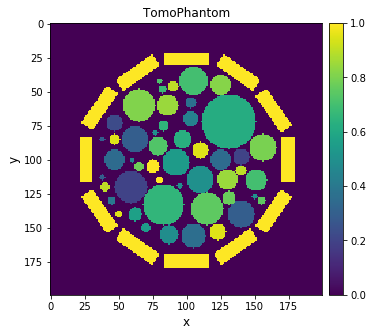

In [2]:
model = 12 # select a model number from the library
N = 200 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom = TomoP2D.Model(model, N, path_library2D) 

# Define image geometry.
ig = ImageGeometry(voxel_num_x = N, voxel_num_y = N)
im_data = ig.allocate()
im_data.fill(phantom)

show(im_data, title = 'TomoPhantom')

The next step is to create an __AcquisitionGeometry__ and __AcquisitionData__ using a __Projection Operator__ $\mathcal{A}$.

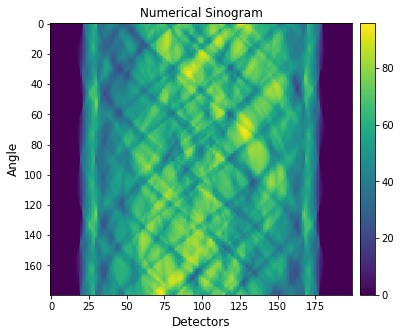

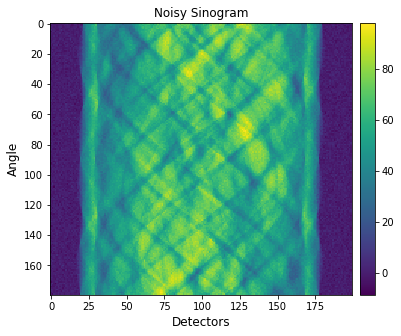

In [3]:
# Create AcquisitionGeometry and AcquisitionData 
detectors = N
angles = np.linspace(0, np.pi, 180, dtype='float32')
ag = AcquisitionGeometry('parallel','2D', angles, detectors)

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = AstraProjectorSimple(ig, ag, device = 'gpu')

# Create an acqusition data (numerically)
sino_num = A.direct(im_data)

# Show numerical sinogram
show(sino_num, title = 'Numerical Sinogram', labels = ['Detectors','Angle'])

# Simulate Gaussian noise for the sinogram
gaussian_var = 2
gaussian_mean = 0 # or np.mean(sino_num.as_array())
n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
sino_noisy = ag.allocate()
sino_noisy.fill(n1+sino_num.as_array())
show(sino_noisy, title = 'Noisy Sinogram', labels = ['Detectors','Angle'])

Then, in order to write our [problem](#Lasso) into this [form](#PDHG_form), we let

1. $K = \mathcal{A} \quad \Longleftrightarrow \quad $ `K = A`  

1. $\mathcal{F}: Y \rightarrow \mathbb{R}, \mbox{ with } \mathcal{F}(z) := \frac{1}{2}\| z - g \|^{2}, \quad \Longleftrightarrow \quad$ ` F = 0.5 * L2NormSquared(sino_noisy)`

1. $\mathcal{G}: X \rightarrow \mathbb{R}, \mbox{ with } \mathcal{G}(z) := \|z\|_{1}, \quad \Longleftrightarrow \quad$ ` G = L1Norm()`.

**Note**: In order to use the PDHG algorithm, we do not need to setup the objective function, but rather the functions $\mathcal{F}, \mathcal{G}$ and operator $K$ that form the objective.

Hence, we can verify that with the above setting we end up with this [form](#PDHG_form) for $x=u$,  $$\underset{u}{\operatorname{argmin}} \frac{1}{2}\|\mathcal{A} u - g\|^{2}_{2} + \alpha\|u\|_{1} = 
\underset{u}{\operatorname{argmin}} \mathcal{F}(\mathcal{A}u) + \mathcal{G}(u) = \underset{x}{\operatorname{argmin}} \mathcal{F}(Kx) + \mathcal{G}(x) $$

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          4.76419e+07
      100        500         0.005          1.60394e+07
      200        500         0.005          9.69613e+05
      300        500         0.005          9.47146e+05
      400        500         0.005          9.41068e+05
      500        500         0.005          9.38220e+05


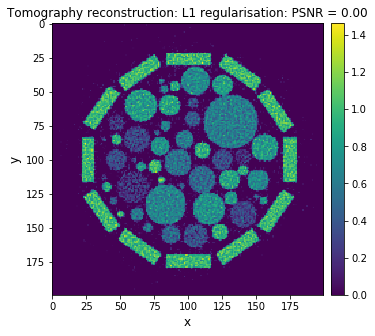

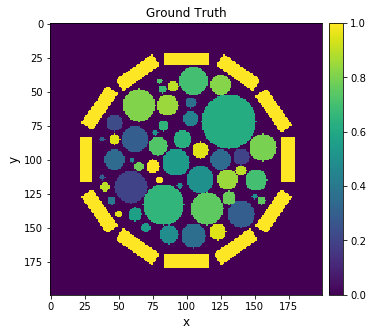

In [6]:
# Define operator K, functions F and G
K = A
F = 0.5 * L2NormSquared(b=sino_noisy)

alpha = 1e2
G = alpha * L1Norm()

# Compute operator norm and step-sizes sigma/tau, such that sigma*tau*||K||^{2}<1
normK = K.norm()
sigma = 1
tau = 1/(sigma*normK**2)

# sigma = 1/normK
# tau = 1/normK

# sigma = 0.001
# tau = 1/(sigma*normK**2)

# Setup and run PDHG
pdhg = PDHG(f = F, g = G, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 500,
            update_objective_interval = 100)
pdhg.run()

recon = pdhg.get_output()

# Compute PSNR quality measure, and show reconstuction and ground truth
PSNR = 0#compare_psnr(im_data.as_array(), recon.as_array())

show(recon, title = 'Tomography reconstruction: L1 regularisation: PSNR = {0:.2f}'.format(PSNR))
show(im_data, title = 'Ground Truth')         

## Exercise 1: PDHG Convergence 

We say that the PDHG converges if the __Primal-Dual Gap = Primal objective + Dual objective__ $\rightarrow 0 $, see [here](#Appendix) . 

Moreover, the speed of convergence of the PDHG algorithm depends heavily on the choise of step-sizes $\sigma$ and $\tau$. Notice, that in the above example, we fix $\sigma=1$ , $\tau = \frac{1}{\sigma\|K\|^{2}}$ and terminate the algorithm after 500 iterations. We can use the code above and consider the following cases:

1. Run PDHG with $\sigma=\frac{1}{\|K\|}$, $\tau = \frac{1}{\|K\|}$ and 500 iterations.
1. Run PDHG with $\sigma=0.001$, $\tau = \frac{1}{\sigma \|K\|^2}$ and 500 iterations. What do you observe?
1. Change regularising parameter such that $\alpha\rightarrow 0$ and $\alpha\rightarrow\infty$. What do you observe for these asympotic choises of $\alpha$?

# Total Variation Regularisation

In this section, we would like to use the PDHG algorithm with the Total variation regulariser defined [here](#TomoTV). Compared to the [Tikhonov](#Tikhonov) problem, we use $L = \nabla$ but with a non-smooth term which is the __MixedL21Norm__ define [here](#TomoTV). In addition, we enforce a positivity constraint for our solution using $\mathbb{I}_{\{u>0\}}(u)$.

## BlockFunction

In order to setup the above [problem](#TomoTV) we need to use the __BlockFramework__ and in particular the concepts of __BlockOperator__, __BlockDataContainer__ and __BlockFunction__. In the previous demos, we have already discussed BlockOperator and BlockDataContainer. 

BlockFunction behaves similarly to a BlockOperator/BlockDataContainer but instead of _stacking_ operators or DataContainers we _append_ functions as below:

$$ F = [f_{1}, f_{2}]$$

For example, let 

$$\begin{align}
f_{1}: Y \rightarrow \mathbb{R}, \quad f_{1}(z_{1}) = \alpha\,\|z_{1}\|_{2,1}, \mbox{ ( the TV term ) }\\
f_{2}: X \rightarrow \mathbb{R}, \quad f_{2}(z_{2}) = \frac{1}{2}\|z_{2} - g\|_{2}^{2}, \mbox{ ( the data-fitting term ) }
\end{align}$$

and consider $z = (z_{1}, z_{2})\in Y\times X$, then 
<a id='BlockFunction'></a>
$$F(z) : = F((z_{1},z_{2}) = f_{1}(z_{1}) + f_{2}(z_{2})$$


## Why BlockFunction?

With the above form, $F(z)$ is a __separable sum__ of decoupled functions. __So, why do we need to write in this form__? It turns out, that the __proximal operator of a BlockFunction__ can be separated, i.e., 

$$\mathrm{prox}_{\tau F}(z) = 
\begin{bmatrix}
\mathrm{prox}_{\tau f_1}(z_1)\\
\mathrm{prox}_{\tau f_2}(z_2)
\end{bmatrix} = 
\begin{bmatrix}
\underset{w_{1}\in Y}{\operatorname{argmin}} \tau f_{1}(w_{1}) + \frac{1}{2}\|w_{1} - z_{1}\|^{2}\\
\underset{w_{2}\in X}{\operatorname{argmin}} \tau f_{2}(w_{2}) + \frac{1}{2}\|w_{2} - z_{2}\|^{2}
\end{bmatrix}
$$

Hence, in order to solve the __dual problem__ of the [PDHG](#Appendix) algorithm, we need to solve the two decoupled problems as shown above.

## PDHG for TV regularisation

At this stage, we have all the necessary ingredients in order to setup our PDHG algorithm for Total variation tomography reconstruction. We define K as a BlockOperator, with the Gradient and Projection operator:

$$ K = 
\begin{bmatrix}
\nabla\\
A
\end{bmatrix}
$$

` K = BlockOperator(Grad, A)`

The function $\mathcal{F}$, is a [BlockFunction](#BlockFunction) with 

1. a function $\alpha\|\cdot\|_{2,1}\quad\Longleftrightarrow\quad$ ` MixedL21Norm() ` term that represents the Total variation regularisation ,

1. a function $\|\cdot -g \|_{2}^{2}\quad\Longleftrightarrow\quad$ `L2NormSquared(sino_noisy)` term that represents the data fitting.

Hence, $F = [f1, f2] \quad\Longleftrightarrow\quad $ ` F = BlockFunction( MixedL21Norm(), L2NormSquared(sino_noisy))`

Finally, we have the function $\mathcal{G} = \mathbb{I}_{\{u>0\}}(u) \quad\Longleftrightarrow\quad$ ` G = IndicatorBox(lower=0)`

Again, we can verify that with the above setting we can express our problem into this [form](#PDHG_form), for $x=u$

$$
\begin{align}
\underset{u}{\operatorname{argmin}}\alpha\|\nabla u\|_{2,1} + \frac{1}{2}\|\mathcal{A} u - g\|^{2}_{2} + \mathbb{I}_{\{u>0\}}(u) =  \underset{u}{\operatorname{argmin}} f_{1}(\nabla u) + f_{2}(\mathcal{A}u) + \mathbb{I}_{\{u>0\}}(u) \\ = \underset{u}{\operatorname{argmin}} F(
\begin{bmatrix}
\nabla \\
\mathcal{A}
\end{bmatrix}u) + \mathbb{I}_{\{u>0\}}(u) = 
\underset{u}{\operatorname{argmin}} \mathcal{F}(Ku) + \mathcal{G}(u) = \underset{x}{\operatorname{argmin}} \mathcal{F}(Kx) + \mathcal{G}(x) 
\end{align}
$$



## Exercise 2: Setup and run PDHG algorithm with the Total variation regulariser

Follow the steps below:

1. Define Gradient operator and BlockOperator K. The ImageGeometry, AcquisitionGeometry and Projection Operator and are already.
1. Define BlockFunction F ( do not forget the regularisation parameter )
1. Define Function G
1. Computer operator norm of K, sigma and tau
1. Setup and run PDHG
1. Show reconstruction result

The reconstruction will look like the figure below after running PDHG for 300 iterations, with $\sigma=1$, $\tau = \frac{1}{\sigma\|K\|^{2}}$ and $\alpha=50$.

<img src="images/tv_recon_300iter_alpha_50.png"  width="400"/>

In [7]:
# Define Gradient operator and BlockOperator K

### START CODE HERE (2 lines) ### 
    
    # Grad = Gradient()
    # K = BlockOperator(  ,  )
    
### END CODE HERE ###

# Define BlockFunction F using the MixedL21Norm() and the L2NormSquared() 

### START CODE HERE (5 lines) ### 
    
    # alpha = 50
    # f1 = MixedL21Norm()
    # f2 = L2NormSquared()
    # F = BlockFunction(  ,  )
    
### END CODE HERE ###

# Define BlockFunction G, as a positivity constraint

### START CODE HERE (1 lines) ### 
    
    # G = IndicatorBox()

### END CODE HERE ###

# Compute operator norm and choose step-size sigma and tau such that sigma*tau||K||^{2}<1 (3 lines)  

### START CODE HERE (1 lines) ### 

    # normK = 
    # sigma = 
    # tau = 

### END CODE HERE ###

# Setup and run PDHG

### START CODE HERE (2 lines) ### 

    # pdhg = ..
    # pdhg... 

### END CODE HERE ###

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        300         0.000          4.76419e+07
      100        300         0.006          1.51013e+07
      200        300         0.006          2.16518e+05
      300        300         0.006          2.06900e+05


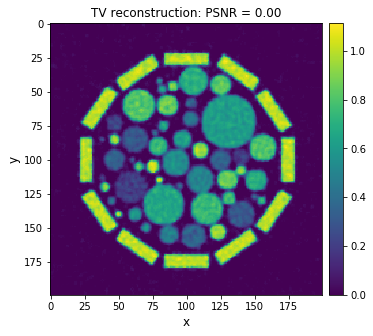

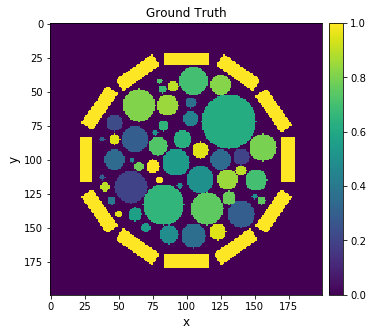

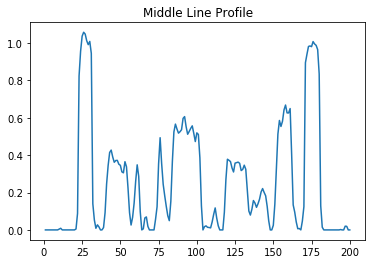

In [8]:
# Define Gradient Operator and BlockOperator 
Grad = Gradient(ig)
K = BlockOperator(Grad,A)

# Define BlockFunction F using the MixedL21Norm() and the L2NormSquared()
alpha = 50
f1 = alpha * MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=sino_noisy)
F = BlockFunction(f1,f2)

# Define BlockFunction G, as a positivity constraint
G = IndicatorBox(lower=0)

# Compute operator norm and choose step-size sigma and tau such that sigma*tau||K||^{2}<1
normK = K.norm()

sigma = 1
tau = 1/(sigma*normK**2)

pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, 
            max_iteration = 300, update_objective_interval = 100)
pdhg.run(verbose = True)

pdhg_tvrecon = pdhg.get_output()

# Compute PSNR quality measure, and show reconstuction and ground truth
PSNR = 0#compare_psnr(im_data.as_array(), pdhg_tvrecon.as_array(), data_range=np.max(im_data.as_array()))

show(pdhg_tvrecon, title = 'TV reconstruction: PSNR = {0:.2f}'.format(PSNR))
show(im_data, title = 'Ground Truth')

plt.figure()
plt.plot(np.linspace(1,N,N), pdhg_tvrecon.as_array()[int(N/2),:])
plt.title('Middle Line Profile')
plt.show()

## Exercise 3: Find the best regulariser for TV reconstruction and compare with FBP and SIRT algorithms

For this exercise, we ask the user to

1. Run TV reconstruction with 5 different regularising parameters, e.g., $\alpha = [1, 10, 50, 500, 1e3, 1e4]$.
1. Choose the best reconstruction according to the highest PSNR.
1. Replace the _MixedL21Norm_ with the _L2NormSquared_ in the _BlockFunction_ definition. Can you identify this minimisation problem?What do you observe
1. Run FBP and SIRT.

__Hint__: For the prima/dual step size we set:
$$
\begin{align}
\sigma_{i} = \frac{C\alpha_{i}}{\|K\|}\\
\tau_{i} = \frac{1}{C\alpha_{i}\|K\|}
\end{align}
$$

Finally, we would like to setup and run FBP and SIRT reconstructions. Recall, for FBP we write

` fbp = FBP(ig, ag, filter_type = 'ram-lak') `

` fbp.set_input(sino_noisy)`

` fbp_recon = fbp.get_output()` 

and for SIRT

` x_init = ig.allocate()` 

` sirt = SIRT(x_init = x_init, operator = A, data=sino_noisy, constraint = IndicatorBox(lower=0),max_iteration = 50)`

` sirt.run(verbose=False) `

` sirt_recon = sirt.get_output() `

 __(Reminder)__ : If $\mathcal{A} u = g$, then:  $$u^{k+1} = \mathcal{P}_{C}(u^{k} + D \mathcal{A}^{T} M ( g - \mathcal{A} u^{k}))$$ where,
 $$
    \begin{cases}
    M = \frac{\mathbb{1}}{\mathcal{A}\mathbb{1}}, \quad m_{ii} = \frac{1}{\sum_{j} a_{ij}}, \quad\mbox{ sum over columns }\\
    D = \frac{\mathbb{1}}{\mathcal{A}^{T}\mathbb{1}}, \quad d_{jj} = \frac{1}{\sum_{i} a_{ij}}\quad\mbox{ sum over rows }\\
    \end{cases}
    $$
    
and $\mathcal{P}_{C}$ is a projection onto a convex set C. For this demo, we will use a positivity constraint.    

In [9]:
# Create a list of possible regularisation parameters

### START CODE HERE (1 line) ### 
    
    # alpha = [ , , , , , ]
    
### END CODE HERE ###

# Compute operator norm and choose step-size sigma and tau such that sigma*tau||K||^{2}<1

### START CODE HERE (1 line) ### 
    
    # normK = 
    
### END CODE HERE ###

# Allocate space for all the TV reconstructions and PSNRs

### START CODE HERE (2 lines) ### 
    
    # recon_all = np.zeros( ((len(alpha),) + ig.shape))
    # PSNR = np.zeros(len(alpha)) 
    
### END CODE HERE ###

# Define function G, and data-fitting term that is an function-element of the BlockFunction

### START CODE HERE (2 lines) ### 
    
    # G = IndicatorBox()
    # f2 = L2NormSquared()
    
### END CODE HERE ###

# Define function G, and data-fitting term that is an function-element of the BlockFunction

### START CODE HERE (2 lines) ### 

    # C = 10
    
    #for i in range(len(alpha)):

    #    sigma = C*alpha[i]/normK
    #    tau = 1/(C*alpha[i]*normK)    

    #    f1 = ...
    #    F = BlockFunction(..., ...)

    #    pdhg = PDHG(f = ..., g = ..., operator = ..., tau = ..., sigma = ..., 
    #            max_iteration = 1000, update_objective_interval = 500)
    #    pdhg.run(verbose = True)

    #    recon_all[i] = pdhg.get_output().as_array()

        # Compute PSNR quality measure, and show reconstuction and ground truth
    #    PSNR[i] =  compare_psnr(im_data.as_array(), recon_all[i] )

    #    show(pdhg.get_output(), title = 'TV reconstruction: alpha = {0:.2f}'.format(alpha[i]))
    #    plt.pause(0.5)
    
### END CODE HERE ###

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          4.76419e+07
      500       1000         0.006          4.04501e+06
     1000       1000         0.006          5.28552e+04


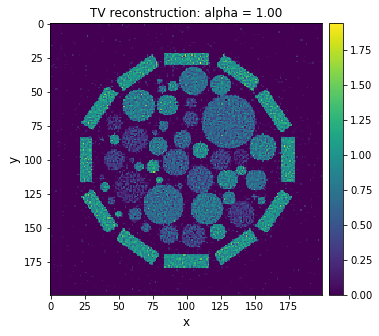

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          4.76419e+07
      500       1000         0.006          9.49733e+06
     1000       1000         0.006          9.05849e+04


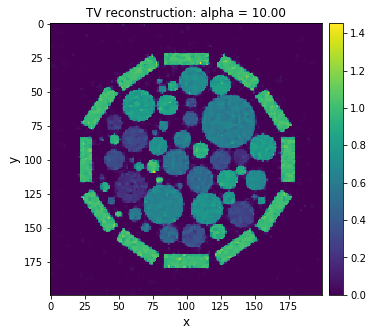

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          4.76419e+07
      500       1000         0.006          2.73759e+07
     1000       1000         0.006          1.94982e+05


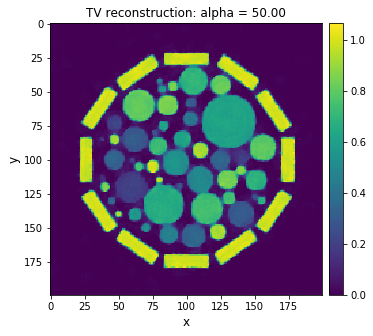

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          4.76419e+07
      500       1000         0.006          4.46060e+07
     1000       1000         0.006          1.15317e+06


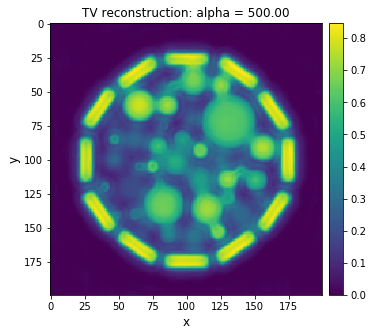

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          4.76419e+07
      500       1000         0.006          4.60839e+07
     1000       1000         0.006          1.85884e+06


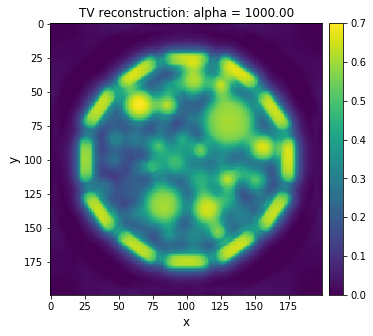

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          4.76419e+07
      500       1000         0.006          4.74845e+07
     1000       1000         0.006          1.16362e+07


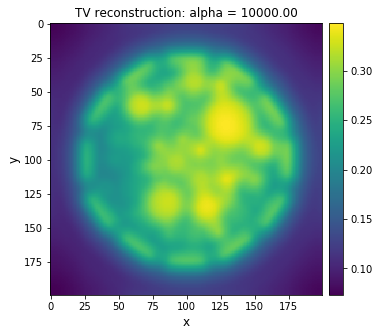

In [11]:
# Define BlockFunction F using the MixedL21Norm() and the L2NormSquared()
alpha = [1, 10, 50, 500, 1e3, 1e4]

# Compute operator norm and choose step-size sigma and tau such that sigma*tau||K||^{2}<1
normK = K.norm()
C = 10

recon_all = np.zeros( ((len(alpha),) + ig.shape))
PSNR = np.zeros(len(alpha))

# Define BlockFunction G, as a positivity constraint
G = IndicatorBox(lower=0)
f2 = 0.5 * L2NormSquared(b=sino_noisy)

for i in range(len(alpha)):
    
    sigma = C*alpha[i]/normK
    tau = 1/(C*alpha[i]*normK)    
    
    f1 = alpha[i] * MixedL21Norm()
    F = BlockFunction(f1, f2)

    pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, 
            max_iteration = 1000, update_objective_interval = 500)
    pdhg.run(verbose = True)

    recon_all[i] = pdhg.get_output().as_array()

    # Compute PSNR quality measure, and show reconstuction and ground truth
    PSNR[i] =  0#compare_psnr(im_data.as_array(), recon_all[i] )
    
    show(pdhg.get_output(), title = 'TV reconstruction: alpha = {0:.2f}'.format(alpha[i]))
    plt.pause(0.5)
 



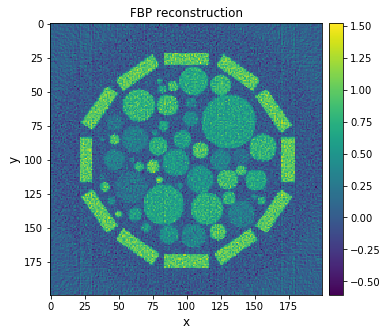

In [12]:
# FBP reconstruction
fbp = FBP(ig, ag, filter_type = 'ram-lak')
fbp.set_input(sino_noisy)
fbp_recon = fbp.get_output()
show(fbp_recon, title = 'FBP reconstruction')

SIRT setting up
SIRT configured


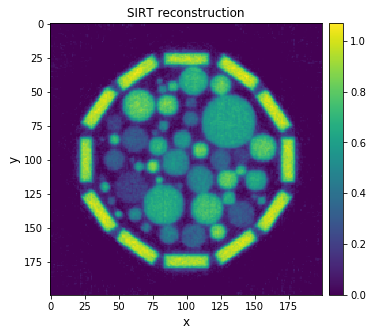

In [13]:
# Run SIRT algoritm, with positivity constraint

# Setup and run the SIRT algorithm  
x_init = ig.allocate()  

sirt = SIRT(x_init = x_init, operator = A, data=sino_noisy, constraint = IndicatorBox(lower=0),
           max_iteration = 50)
sirt.run(verbose=False)

sirt_recon = sirt.get_output()
show(sirt_recon, title = 'SIRT reconstruction')

In [14]:
print('The parameters are {}  '.format(alpha))
print('The PSNR values {}  '.format(PSNR))

The parameters are [1, 10, 50, 500, 1000.0, 10000.0]  
The PSNR values [0. 0. 0. 0. 0. 0.]  


In [15]:
from utilities import islicer
stack_recon = ImageData(np.array([fbp_recon.as_array(), 
                                  sirt_recon.as_array(),
                                  recon_all[1],
                                  recon_all[2],
                                  im_data.as_array()]))
islicer(stack_recon, 0, minmax=(0,1))

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=4), Output()), _dom_cla…

IntSlider(value=0, continuous_update=False, description='x', max=4)

<h1><center>End of Demo </center></h1>

<a id='Appendix'></a>
# Appendix

The PDHG algorithm is described below :
    
<center> Choose step-sizes $\tau$, $\sigma$, such that $\tau\sigma\|K\|^{2}<1$ </center> 
<center> Choose $\theta\in[0,1]$ </center>
<center> Let $(x^{0}, y^{0})\in X\times Y$ and $\overline{x}^{0} = x^{0}$ </center>
<br>
\begin{align}
    y^{n+1}  & = \mathrm{prox}_{\sigma\mathcal{F}^{*}}( y^{n} + \sigma K \overline{x}^{n} )\quad \mbox{ (Dual Problem)}\tag{1}\\[10pt]
    x^{n+1}  & = \mathrm{prox}_{\tau\mathcal{G}^{*}} ( x^{n} - \tau K^{*} \overline{x}^{n} )\quad \mbox{ (Primal Problem) }\tag{2}\\[10pt]
    \overline{x}^{n+1} & = x^{n+1} + \theta ( x^{n+1} - x^{n} )\quad\mbox{ (Over-relaxation step) }
\end{align}

<a id='Proximal'></a>
__**Proximal Operator**__: Let $\lambda>0$ and $f$ a convex function. Then

$$
z : = \mbox{prox}_{\lambda f}(x) = \underset{z}{\operatorname{argmin}} \frac{1}{2}\|z - x \|^{2} + \lambda f(z) 
$$
 
__**Note**__: We assume that proximal operators have a closed form solution or can be solved efficiently using an iterative algorithm.

__**Primal-Dual Gap (PD)**__:

$$\mbox{PD} = \mathcal{F}(Kx) + \mathcal{G}(x) + \mathcal{F}^{*}(y) + \mathcal{G}(-K^{T}y) $$